In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import os

os.environ['CUDA_VISIBLE_DEVICES']="0"


from keras.layers import Dense, Input
from keras.models import Model

import omnifold6 as of

import tensorflow as tf


## Set model and resolution parameters

In [2]:
train_mu0 = 0.
train_mu1 = 1.
train_rho01 = -0.6

train_sig0 = 1.0
train_sig1 = 1.5

train_cov00 = train_sig0 * train_sig0 
train_cov11 = train_sig1 * train_sig1
train_cov01 = train_rho01 * train_sig0 * train_sig1

train_cov = np.array( [[train_cov00, train_cov01], [train_cov01, train_cov11]] )
train_mu = np.array( [train_mu0, train_mu1])



true_mu0 = 0.2
true_mu1 = 0.8
true_rho01 = -0.6

true_sig0 = 0.9
true_sig1 = 1.3

true_cov00 = true_sig0 * true_sig0 
true_cov11 = true_sig1 * true_sig1
true_cov01 = true_rho01 * true_sig0 * true_sig1

true_cov = np.array( [[true_cov00, true_cov01], [true_cov01, true_cov11]] )
true_mu = np.array( [true_mu0, true_mu1])



#--- resolution is in same dimensions as features (not sigma/val)
res0 = 0.5
res1 = 0.8

#res0 = 0.001
#res1 = 0.001

res0 = 1.0
res1 = 1.6




#ngen_train = 100000
#ngen_true  =  10000

ngen_train =  1000000
ngen_true  =   100000

#ngen_train =  4000000
#ngen_true  =   400000

#ngen_train =  1000000
#ngen_true  =    10000

ngen_train =  8000000
ngen_true  =   100000



of_niter = 6

learning_rate_setval = 0.0005

epochs_setval = 20

batch_size_setval = int( ngen_true )


## Plots to visualize these parameter choices

In [3]:


train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, [res0, res1])

true_det_pts = np.random.normal( true_pts, [res0, res1])



In [4]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.21.5
  tensorflow version:  2.11.0





<function matplotlib.pyplot.show(close=None, block=None)>

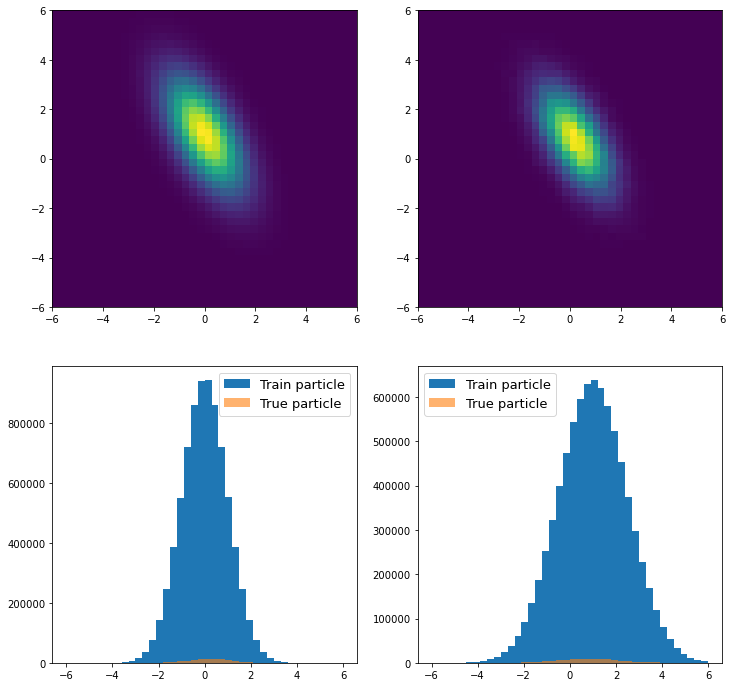

In [5]:
fig,ax = plt.subplots( 2, 2, figsize=(12,12))

hmin=-6
hmax=6
hbins=40

ax[0][0].hist2d( train_pts[:,0], train_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[0][1].hist2d( true_pts[:,0], true_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[1][0].hist( train_pts[:,0], bins=hbins, range=[hmin,hmax], label='Train particle' )
ax[1][0].hist( true_pts[:,0], bins=hbins, range=[hmin,hmax], label='True particle', alpha=0.6)

ax[1][1].hist( train_pts[:,1], bins=hbins, range=[hmin,hmax], label='Train particle' )
ax[1][1].hist( true_pts[:,1], bins=hbins, range=[hmin,hmax], label='True particle', alpha=0.6)


ax[1][0].legend(loc='best', fontsize=13)
ax[1][1].legend(loc='best', fontsize=13)

plt.show

In [6]:
train_diff = train_det_pts - train_pts

In [7]:
diff_cov = np.cov( train_diff.T )

In [8]:
diff_cov

array([[ 1.00040646e+00, -5.24573221e-04],
       [-5.24573221e-04,  2.55986688e+00]])

In [9]:
np.sqrt(diff_cov[0,0])

1.0002032075915581

In [10]:
np.sqrt(diff_cov[1,1])

1.5999584007666428

<function matplotlib.pyplot.show(close=None, block=None)>

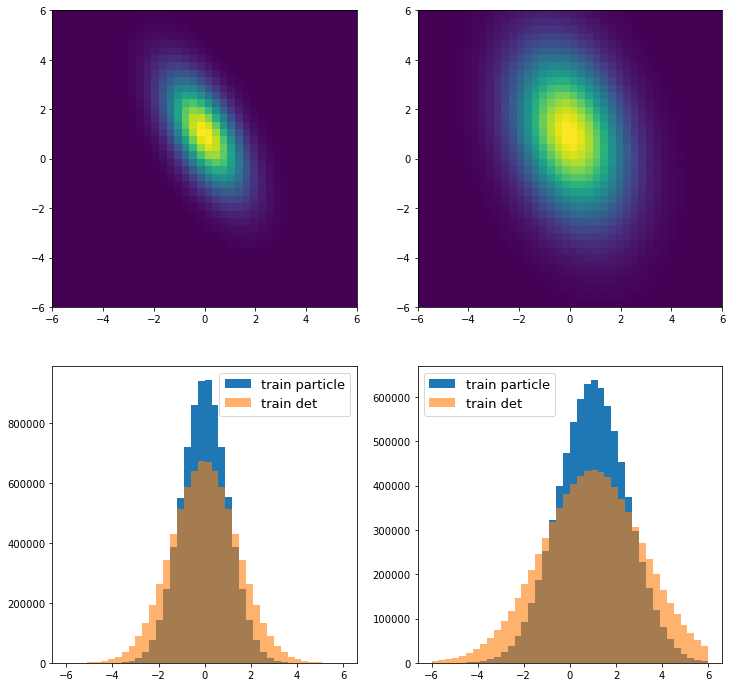

In [11]:
fig,ax = plt.subplots( 2, 2, figsize=(12,12))

hmin=-6
hmax=6
hbins=40

ax[0][0].hist2d( train_pts[:,0], train_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[0][1].hist2d( train_det_pts[:,0], train_det_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[1][0].hist( train_pts[:,0], bins=hbins, range=[hmin,hmax], label='train particle' )
ax[1][0].hist( train_det_pts[:,0], bins=hbins, range=[hmin,hmax], label='train det', alpha=0.6)

ax[1][1].hist( train_pts[:,1], bins=hbins, range=[hmin,hmax], label='train particle' )
ax[1][1].hist( train_det_pts[:,1], bins=hbins, range=[hmin,hmax], label='train det', alpha=0.6)


ax[1][0].legend(loc='best', fontsize=13)
ax[1][1].legend(loc='best', fontsize=13)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

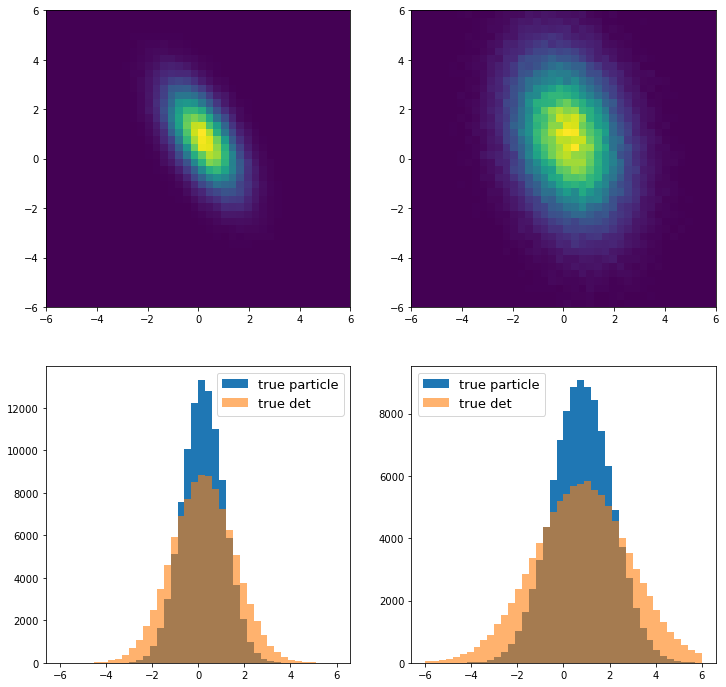

In [12]:
fig,ax = plt.subplots( 2, 2, figsize=(12,12))

hmin=-6
hmax=6
hbins=40

ax[0][0].hist2d( true_pts[:,0], true_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[0][1].hist2d( true_det_pts[:,0], true_det_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[1][0].hist( true_pts[:,0], bins=hbins, range=[hmin,hmax], label='true particle' )
ax[1][0].hist( true_det_pts[:,0], bins=hbins, range=[hmin,hmax], label='true det', alpha=0.6)

ax[1][1].hist( true_pts[:,1], bins=hbins, range=[hmin,hmax], label='true particle' )
ax[1][1].hist( true_det_pts[:,1], bins=hbins, range=[hmin,hmax], label='true det', alpha=0.6)


ax[1][0].legend(loc='best', fontsize=13)
ax[1][1].legend(loc='best', fontsize=13)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

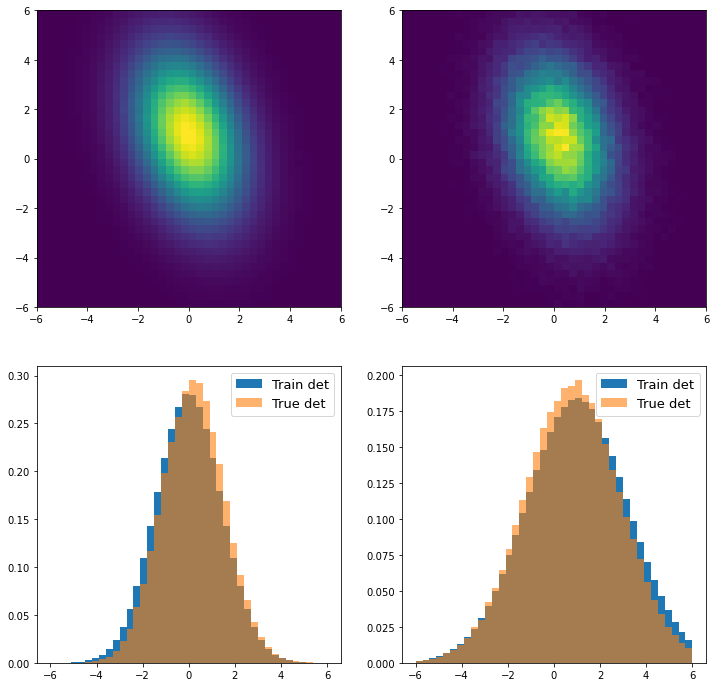

In [13]:
fig,ax = plt.subplots( 2, 2, figsize=(12,12))

hmin=-6
hmax=6
hbins=40

ax[0][0].hist2d( train_det_pts[:,0], train_det_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[0][1].hist2d( true_det_pts[:,0], true_det_pts[:,1], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))

ax[1][0].hist( train_det_pts[:,0], bins=hbins, density=True, range=[hmin,hmax], label='Train det' )
ax[1][0].hist( true_det_pts[:,0], bins=hbins, density=True, range=[hmin,hmax], label='True det', alpha=0.6)

ax[1][1].hist( train_det_pts[:,1], bins=hbins, density=True, range=[hmin,hmax], label='Train det' )
ax[1][1].hist( true_det_pts[:,1], bins=hbins, density=True, range=[hmin,hmax], label='True det', alpha=0.6)


ax[1][0].legend(loc='best', fontsize=13)
ax[1][1].legend(loc='best', fontsize=13)

plt.show

## Set up NN model for OmniFold

In [14]:
inputs = Input((2, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

2023-12-02 11:10:05.680407: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 11:10:05.698686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 11:10:05.698981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 11:10:05.702306: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 11:10:05.702501: I tensorflow/compiler/xla/stream_executo

## Package the training data for OmniFold

In [15]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

## Run OmniFold

In [16]:
%%time


verbose = True






of_return_dict = of.omnifold6( 
    train_both, true_det_pts, of_niter, model, verbose, 
    batch_size_setval, learning_rate_setval, epochs_setval )

of_weights = of_return_dict["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = of_return_dict["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = of_return_dict["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights






  ======== omnifold6


  shape of theta0_S : (8000000, 2)
  shape of theta_unknown_S : (100000, 2)
  shape of xvals_1 :  (8100000, 2)



  shape of labels0 : (8000000,)
  shape of labels_unknown : (100000,)
  shape of yvals_1 :  (8100000,)



  shape of theta0_G : (8000000, 2)
  shape of xvals_2 :  (16000000, 2)
  shape of yvals_2 :  (16000000,)

 batch size setval  100000
 learning rate setval  0.000500
 epochs setval  20




ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
             running pre-training, distinguish from self.
Epoch 1/5


2023-12-02 11:10:11.479454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-02 11:10:11.481516: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f15100c3b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-02 11:10:11.481528: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-12-02 11:10:11.485085: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-02 11:10:11.576014: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 [==============================] - 2s 3ms/step - loss: 0.6937 - accuracy: 0.4411
Epoch 2/5
120/120 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4780
Epoch 3/5
120/120 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5053
Epoch 4/5
120/120 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5072
Epoch 5/5
120/120 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4846
             done pretraining.
Epoch 1/40
61/61 [==============================] - 1s 6ms/step - loss: 0.0171 - accuracy: 0.2955 - val_loss: 0.0170 - val_accuracy: 0.3086
Epoch 2/40
61/61 [==============================] - 0s 4ms/step - loss: 0.0171 - accuracy: 0.2987 - val_loss: 0.0170 - val_accuracy: 0.2883
Epoch 3/40
61/61 [==============================] - 0s 4ms/step - loss: 0.0170 - accuracy: 0.2793 - val_loss: 0.0170 - val_accuracy: 0.2724
Epoch 4/40
61/61 [==============================] - 0s 4ms/step 

Epoch 11/40
120/120 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.3975 - val_loss: 0.6911 - val_accuracy: 0.3980
Epoch 12/40
120/120 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.3980 - val_loss: 0.6911 - val_accuracy: 0.3979
Epoch 13/40
120/120 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.3982 - val_loss: 0.6911 - val_accuracy: 0.3980
Epoch 14/40
120/120 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.3981 - val_loss: 0.6911 - val_accuracy: 0.3986
Epoch 15/40
120/120 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.3985 - val_loss: 0.6911 - val_accuracy: 0.3984
Epoch 16/40
120/120 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.3985 - val_loss: 0.6911 - val_accuracy: 0.3979
Epoch 17/40
120/120 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.3984 - val_loss: 0.6911 - val_accuracy: 0.3987

120/120 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.6153
Epoch 3/5
120/120 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.6109
Epoch 4/5
120/120 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.6123
Epoch 5/5
120/120 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.6084
             done pretraining.
Epoch 1/20
120/120 [==============================] - 1s 4ms/step - loss: 0.6877 - accuracy: 0.2499 - val_loss: 0.6877 - val_accuracy: 0.2502
Epoch 2/20
120/120 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.2500 - val_loss: 0.6876 - val_accuracy: 0.2501
Epoch 3/20
120/120 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.2499 - val_loss: 0.6876 - val_accuracy: 0.2502
Epoch 4/20
120/120 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.2499 - val_loss: 0.6876 - val_accuracy: 0.2501
Epoch 5/20
120/

120/120 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.2500 - val_loss: 0.6882 - val_accuracy: 0.2501
Epoch 6/20
120/120 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.2500 - val_loss: 0.6882 - val_accuracy: 0.2501
Epoch 7/20
120/120 [==============================] - 1s 4ms/step - loss: 0.6882 - accuracy: 0.2500 - val_loss: 0.6882 - val_accuracy: 0.2501
Epoch 8/20
120/120 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.2500 - val_loss: 0.6882 - val_accuracy: 0.2501
Epoch 9/20
120/120 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.2500 - val_loss: 0.6882 - val_accuracy: 0.2501
Epoch 10/20
120/120 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.2500 - val_loss: 0.6882 - val_accuracy: 0.2500
Epoch 11/20
120/120 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.2500 - val_loss: 0.6882 - val_accuracy: 0.2501
Epoch 12/20
120

120/120 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.2500 - val_loss: 0.6956 - val_accuracy: 0.2501
Epoch 13/20
120/120 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.2499 - val_loss: 0.6956 - val_accuracy: 0.2501
Epoch 14/20
120/120 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.2500 - val_loss: 0.6956 - val_accuracy: 0.2501
Epoch 15/20
120/120 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.2500 - val_loss: 0.6956 - val_accuracy: 0.2501
Epoch 16/20
120/120 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.2500 - val_loss: 0.6956 - val_accuracy: 0.2501
Epoch 17/20
120/120 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.2500 - val_loss: 0.6956 - val_accuracy: 0.2501
Epoch 18/20
120/120 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.2500 - val_loss: 0.6956 - val_accuracy: 0.2501
Epoch 19/20

120/120 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.2500 - val_loss: 0.6958 - val_accuracy: 0.2499
Epoch 20/20
800/800 [==============================] - 1s 610us/step

ITERATION: 6

   -- ITERATION 6  STEP 1

 weights_push at the beginning
[0.99769929 0.62241285 1.03854128 ... 0.61464584 1.0245327  0.37373616]
             running pre-training, distinguish from self.
Epoch 1/5
120/120 [==============================] - 2s 3ms/step - loss: 0.6932 - accuracy: 0.4919
Epoch 2/5
120/120 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5188
Epoch 3/5
120/120 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4856
Epoch 4/5
120/120 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4985
Epoch 5/5
120/120 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5109
             done pretraining.
Epoch 1/20
61/61 [==============================] - 1s 6ms/step - loss:

In [17]:
of_return_dict

{'train-hist-step1-iter0': <keras.callbacks.History at 0x7f2047869510>,
 'train-hist-step2-iter0': <keras.callbacks.History at 0x7f203f9731c0>,
 'train-hist-step1-iter1': <keras.callbacks.History at 0x7f203c0c9a50>,
 'train-hist-step2-iter1': <keras.callbacks.History at 0x7f2047586aa0>,
 'train-hist-step1-iter2': <keras.callbacks.History at 0x7f201ff7a4a0>,
 'train-hist-step2-iter2': <keras.callbacks.History at 0x7f201c6a29b0>,
 'train-hist-step1-iter3': <keras.callbacks.History at 0x7f201c45cc70>,
 'train-hist-step2-iter3': <keras.callbacks.History at 0x7f201c2acd00>,
 'train-hist-step1-iter4': <keras.callbacks.History at 0x7f201c062830>,
 'train-hist-step2-iter4': <keras.callbacks.History at 0x7f1fedb8e980>,
 'train-hist-step1-iter5': <keras.callbacks.History at 0x7f1fd61880a0>,
 'train-hist-step2-iter5': <keras.callbacks.History at 0x7f201ff7b3a0>,
 'weights': array([[[1.12434602, 0.79502398, 1.03167689, ..., 1.10076582,
          1.15008104, 0.47801301],
         [0.98799652, 0.799

In [18]:
of_return_dict['train-hist-step1-iter0'].history

{'loss': [0.017096856608986855,
  0.017057331278920174,
  0.017044099047780037,
  0.0170380100607872,
  0.01703456975519657,
  0.017032168805599213,
  0.01702965795993805,
  0.0170276015996933,
  0.017025766894221306,
  0.017024489119648933,
  0.017023973166942596,
  0.01702304743230343,
  0.017022453248500824,
  0.017021987587213516,
  0.01702152192592621,
  0.017021242529153824,
  0.017020931467413902,
  0.017020558938384056,
  0.01702049747109413,
  0.01702115684747696,
  0.017020421102643013,
  0.01702021434903145,
  0.017019981518387794,
  0.017019694671034813,
  0.01701986975967884,
  0.01701968163251877,
  0.017019735649228096,
  0.01701955683529377,
  0.01701989211142063,
  0.017019420862197876,
  0.017019422724843025,
  0.017019225284457207,
  0.017019636929035187,
  0.017019370570778847,
  0.017019910737872124,
  0.017019273713231087,
  0.01701899990439415,
  0.01701943576335907,
  0.017019107937812805,
  0.01701878383755684],
 'accuracy': [0.295485258102417,
  0.298704534769

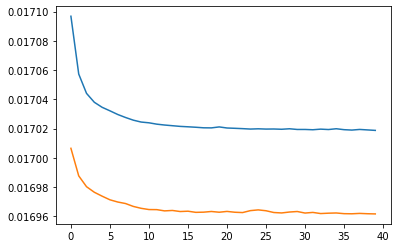

In [19]:
plt.plot( of_return_dict['train-hist-step1-iter0'].history['loss'] )
plt.plot( of_return_dict['train-hist-step1-iter0'].history['val_loss'] )

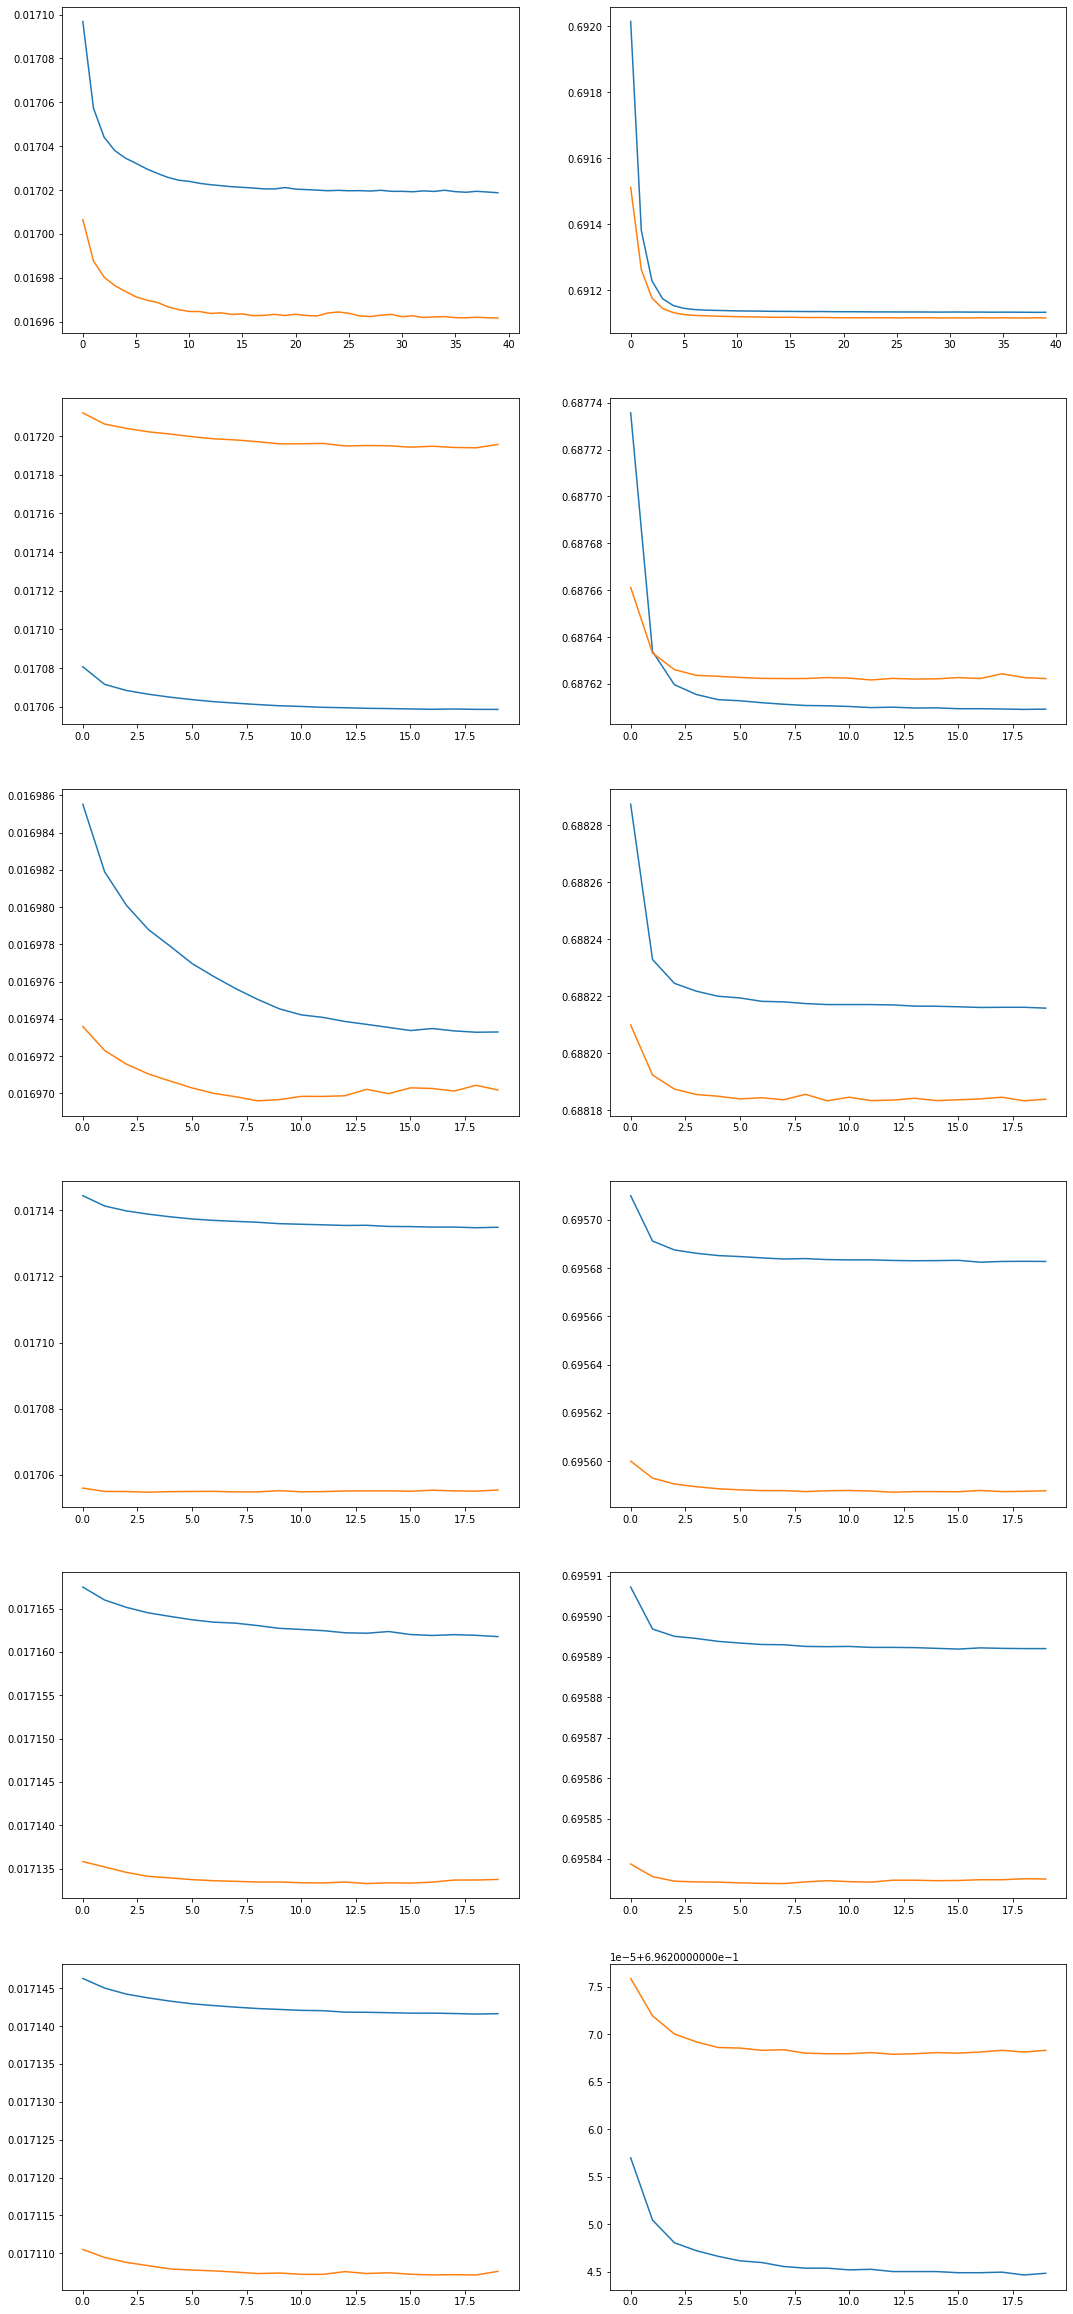

In [20]:
fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

for ofi in range(0,of_niter) :
    
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['loss']  )
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['val_loss']  )

    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['loss']  )
    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['val_loss']  )
    
    #ax[ofi][2].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['loss']  )
    #ax[ofi][2].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['val_loss']  )
    #ax[ofi][2].set_yscale('log')

    #ax[ofi][3].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['loss']  )
    #ax[ofi][3].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['val_loss']  )
    #ax[ofi][3].set_yscale('log')



In [21]:
np.shape( of_weights)

(6, 2, 8000000)

<function matplotlib.pyplot.show(close=None, block=None)>

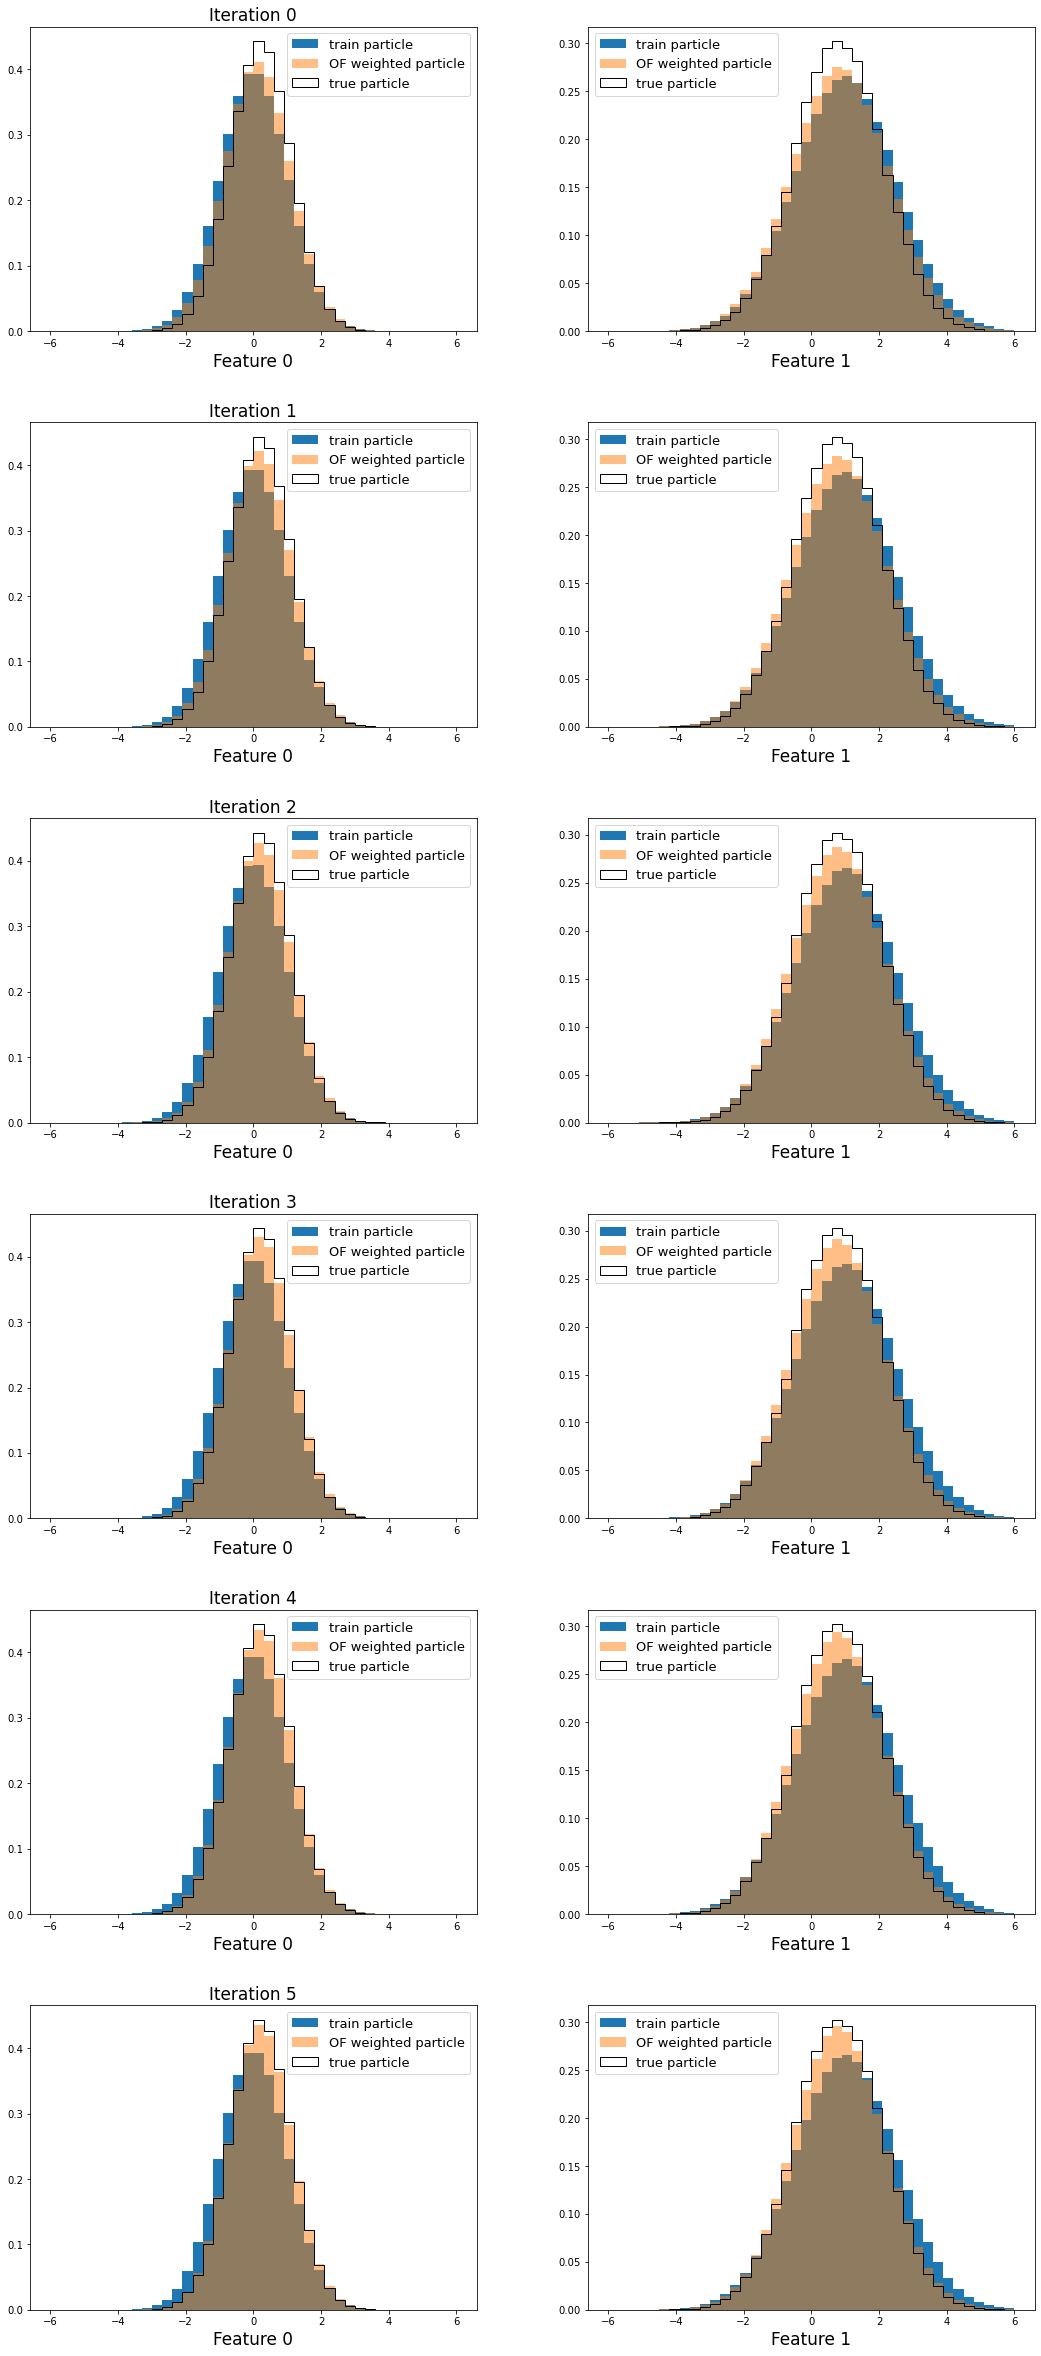

In [22]:


fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,2,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,2,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        ax[ofi][0].hist( train_pts[:,0], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
        hist_data_mc_ofweighted[ofi,0],_,_ = ax[ofi][0].hist( train_pts[:,0], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
        hist_data_truth[ofi,0],_,_ =         ax[ofi][0].hist( true_pts[:,0], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

        ax[ofi][1].hist( train_pts[:,1], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
        hist_data_mc_ofweighted[ofi,1],_,_ = ax[ofi][1].hist( train_pts[:,1], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
        hist_data_truth[ofi,1],_,_ =         ax[ofi][1].hist( true_pts[:,1], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :

        #ax[ofi][0].hist( train_pts[:,0], bins=hbins, range=[hmin,hmax], label='train particle' )
        hist_data_mc_ofweighted[ofi,0],_,_ = ax[ofi][0].hist( train_pts[:,0], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
        hist_data_truth[ofi,0],_,_ =         ax[ofi][0].hist( true_pts[:,0], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

        #ax[ofi][1].hist( train_pts[:,1], bins=hbins, range=[hmin,hmax], label='train particle' )
        hist_data_mc_ofweighted[ofi,1],_,_ = ax[ofi][1].hist( train_pts[:,1], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
        hist_data_truth[ofi,1],_,_ =         ax[ofi][1].hist( true_pts[:,1], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )


    
    ax[ofi][0].legend(loc='best', fontsize=13)
    ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [23]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,2))

for ofi in range( of_niter ) :
    hist_data_sum_diff2[ofi,0] = np.sum( hist_data_diff2[ofi,0])
    hist_data_sum_diff2[ofi,1] = np.sum( hist_data_diff2[ofi,1])

<function matplotlib.pyplot.show(close=None, block=None)>

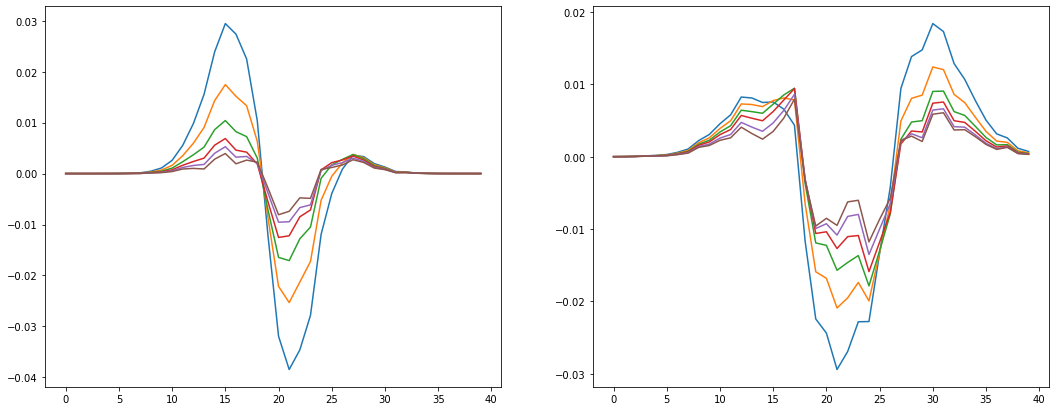

In [24]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

for ofi in range(of_niter) :
    ax[0].plot(hist_data_diff[ofi,0])
    ax[1].plot(hist_data_diff[ofi,1])
    
plt.show    

<function matplotlib.pyplot.show(close=None, block=None)>

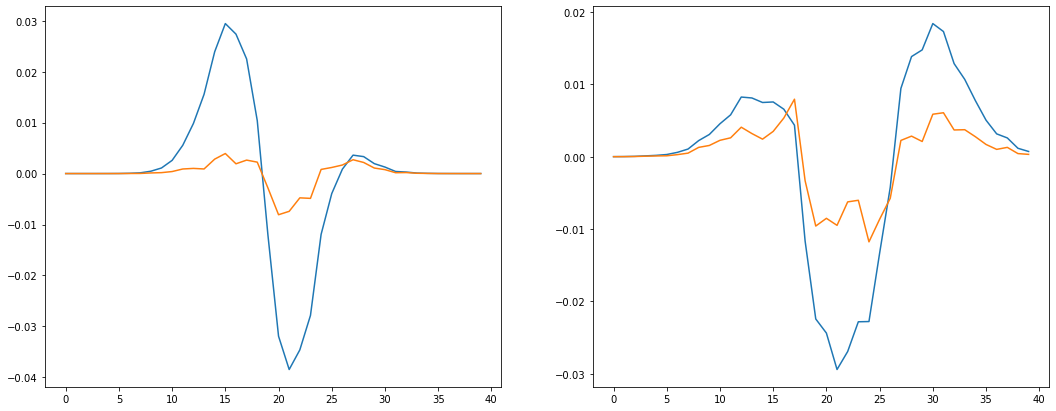

In [25]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))


ax[0].plot(hist_data_diff[0,0])
ax[1].plot(hist_data_diff[0,1])
    
ofi = of_niter-1
ax[0].plot(hist_data_diff[ofi,0])
ax[1].plot(hist_data_diff[ofi,1])

plt.show  

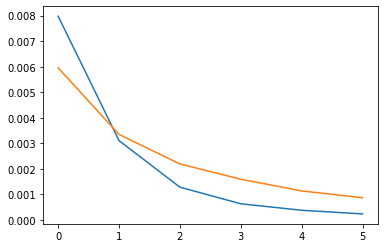

In [26]:
plt.plot( hist_data_sum_diff2)

<function matplotlib.pyplot.show(close=None, block=None)>

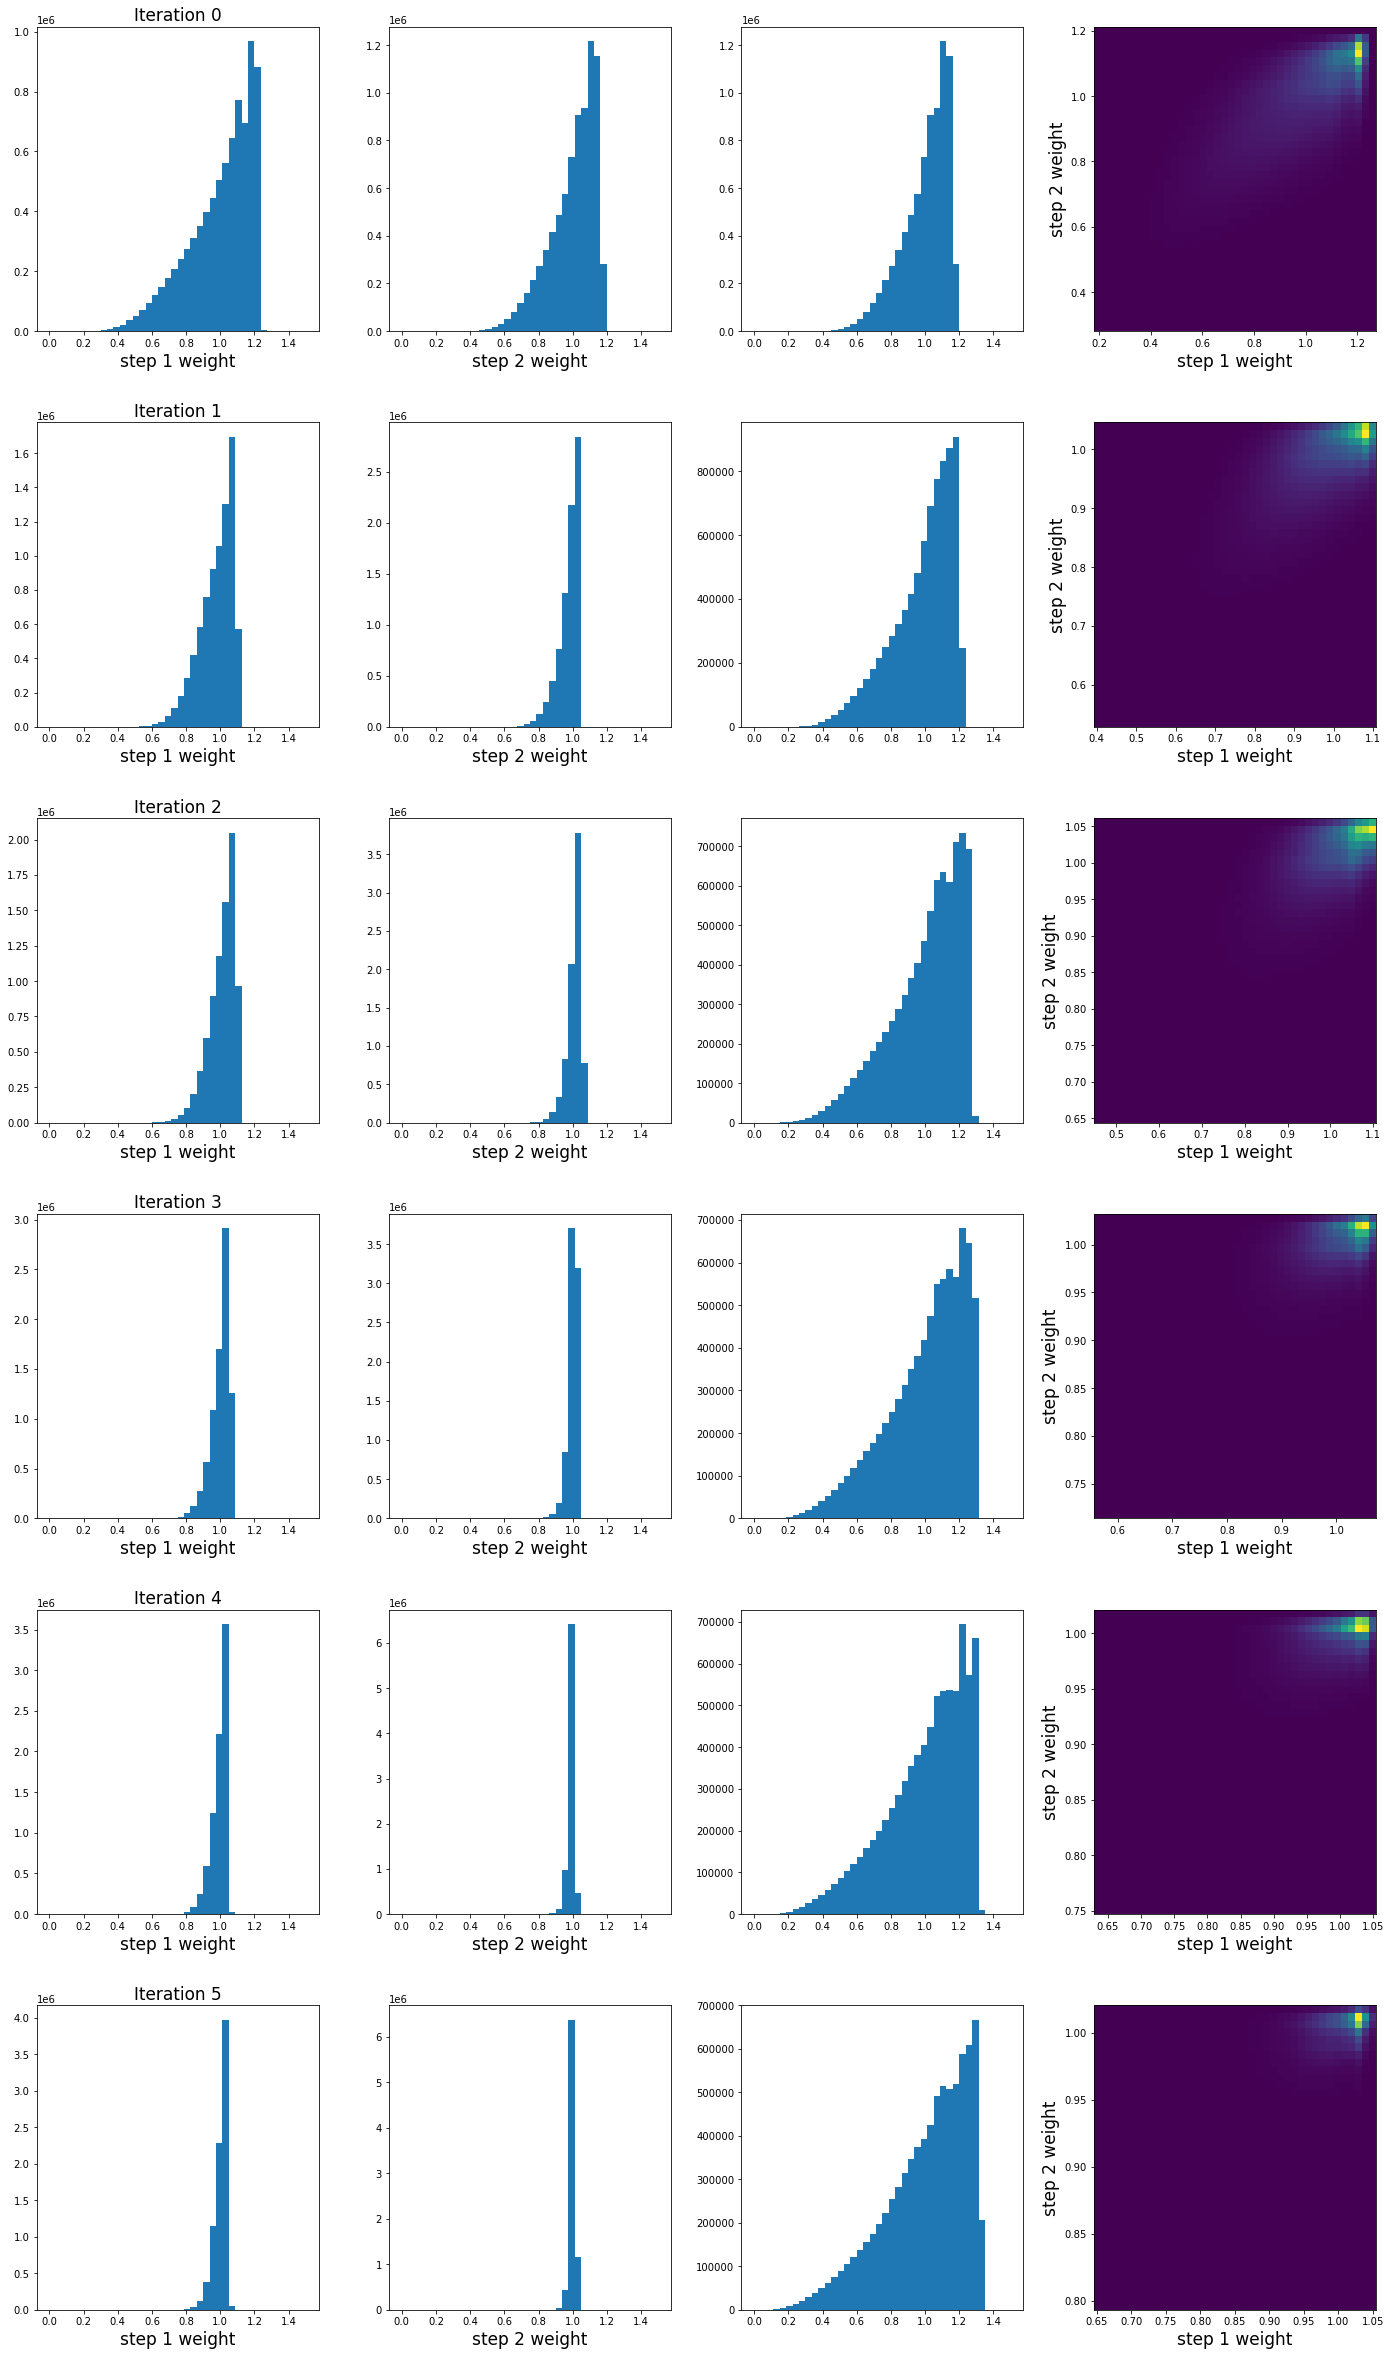

In [27]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

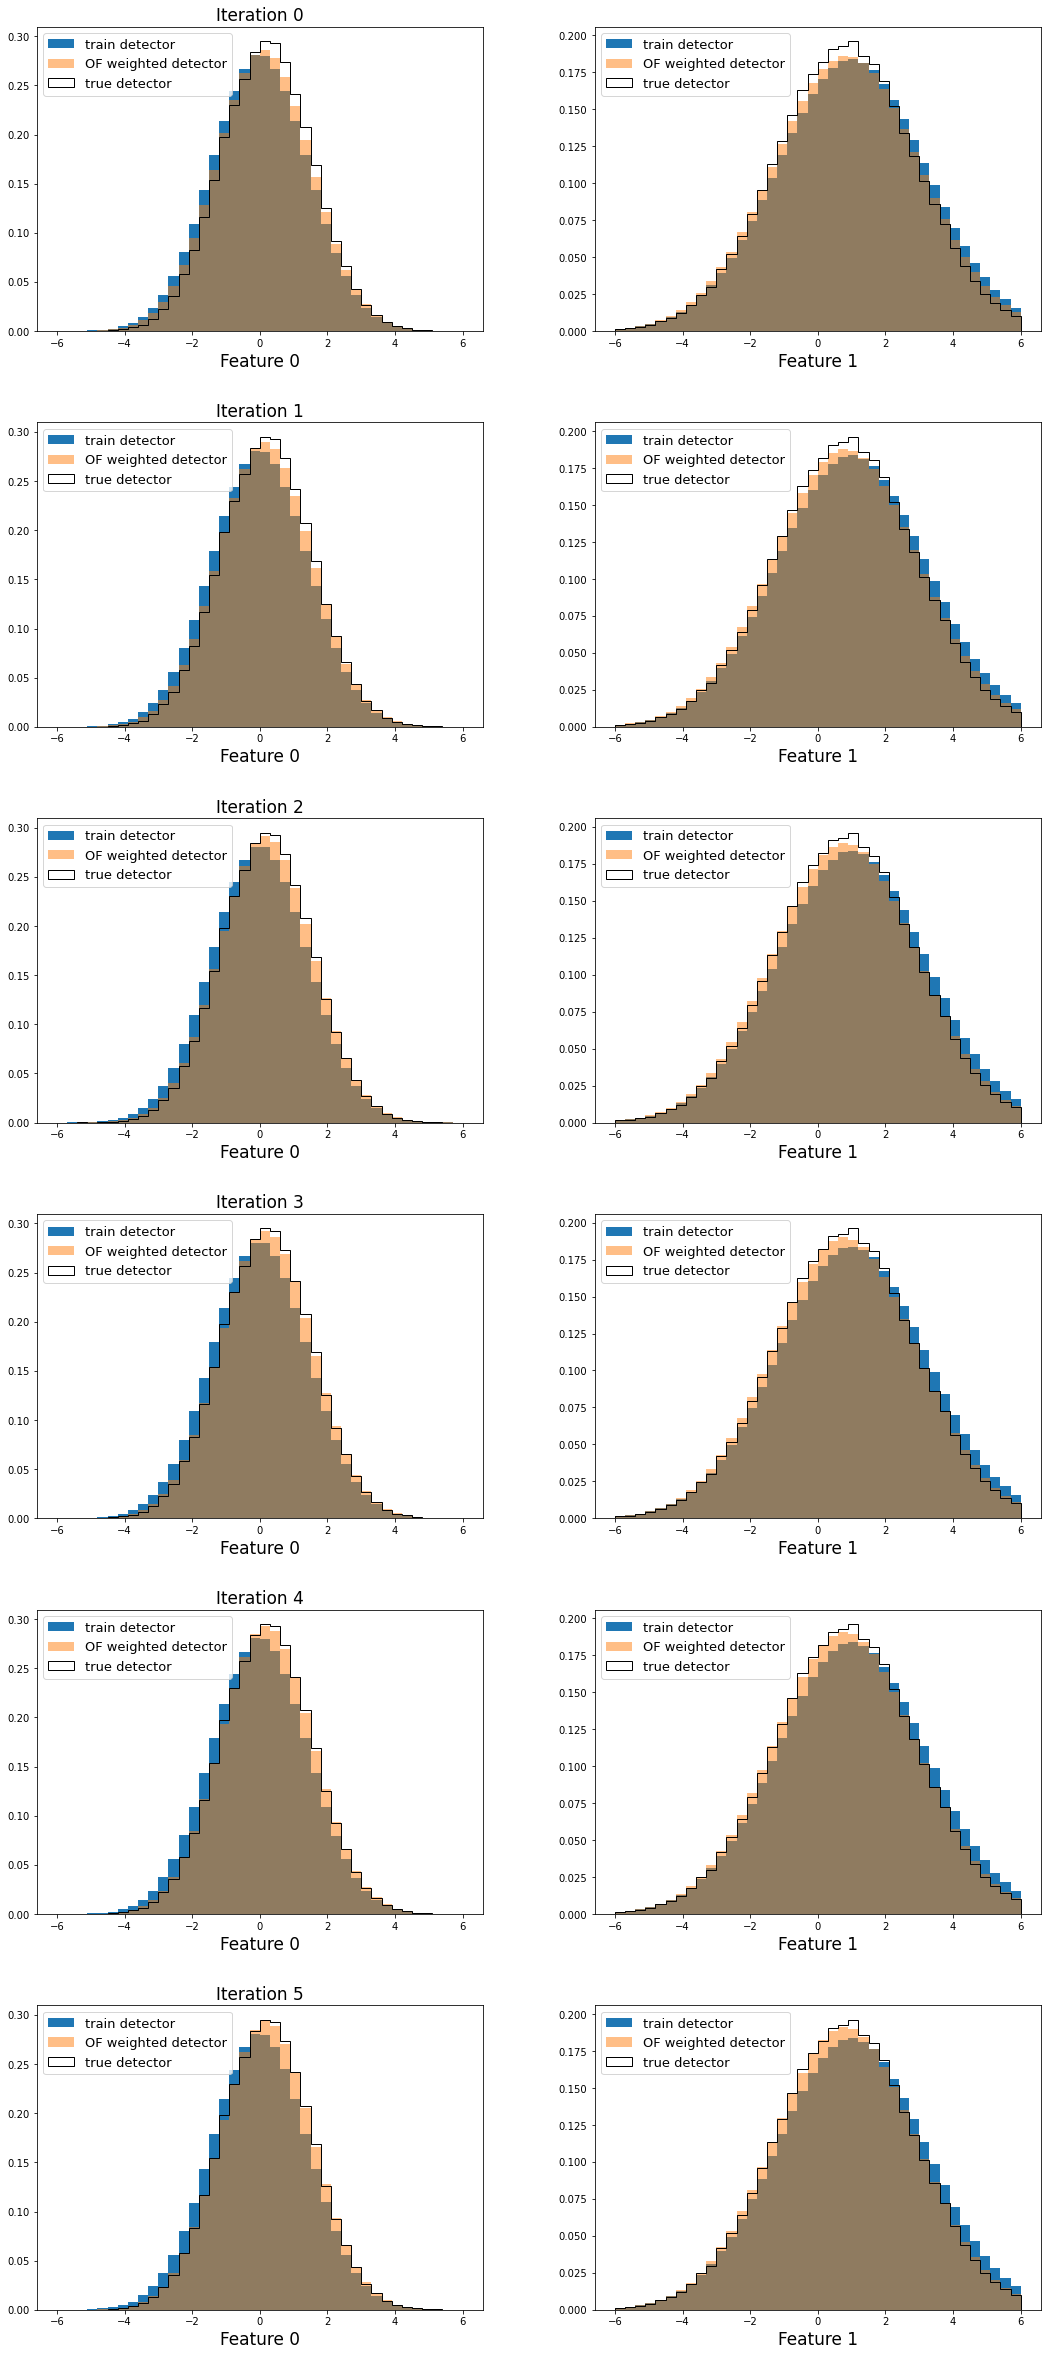

In [28]:


fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,2,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,2,hbins))

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True

for ofi in range(0,of_niter) :

    if do_renorm :
        ax[ofi][0].hist( train_det_pts[:,0], bins=hbins, density=True, range=[hmin,hmax], label='train detector' )
        det_hist_data_mc_ofweighted[ofi,0],_,_ =   ax[ofi][0].hist( train_det_pts[:,0], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted detector', alpha=0.5 )
        det_hist_data_truth[ofi,0],_,_         =   ax[ofi][0].hist( true_det_pts[:,0], bins=hbins, density=True, range=[hmin,hmax], label='true detector', histtype='step', color='black' )

        ax[ofi][1].hist( train_det_pts[:,1], bins=hbins, density=True, range=[hmin,hmax], label='train detector' )
        det_hist_data_mc_ofweighted[ofi,1],_,_ =   ax[ofi][1].hist( train_det_pts[:,1], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted detector', alpha=0.5 )
        det_hist_data_truth[ofi,1],_,_         =   ax[ofi][1].hist( true_det_pts[:,1], bins=hbins, density=True, range=[hmin,hmax], label='true detector', histtype='step', color='black' )

    else :

        #ax[ofi][0].hist( train_det_pts[:,0], bins=hbins, range=[hmin,hmax], label='train detector' )
        det_hist_data_mc_ofweighted[ofi,0],_,_ =   ax[ofi][0].hist( train_det_pts[:,0], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted detector', alpha=0.5 )
        det_hist_data_truth[ofi,0],_,_         =   ax[ofi][0].hist( true_det_pts[:,0], bins=hbins, range=[hmin,hmax], label='true detector', histtype='step', color='black' )

        #ax[ofi][1].hist( train_det_pts[:,1], bins=hbins, range=[hmin,hmax], label='train detector' )
        det_hist_data_mc_ofweighted[ofi,1],_,_ =   ax[ofi][1].hist( train_det_pts[:,1], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted detector', alpha=0.5 )
        det_hist_data_truth[ofi,1],_,_         =   ax[ofi][1].hist( true_det_pts[:,1], bins=hbins, range=[hmin,hmax], label='true detector', histtype='step', color='black' )


    
    ax[ofi][0].legend(loc='best', fontsize=13)
    ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [29]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,2))

for ofi in range( of_niter ) :
    det_hist_data_sum_diff2[ofi,0] = np.sum( det_hist_data_diff2[ofi,0])
    det_hist_data_sum_diff2[ofi,1] = np.sum( det_hist_data_diff2[ofi,1])

<function matplotlib.pyplot.show(close=None, block=None)>

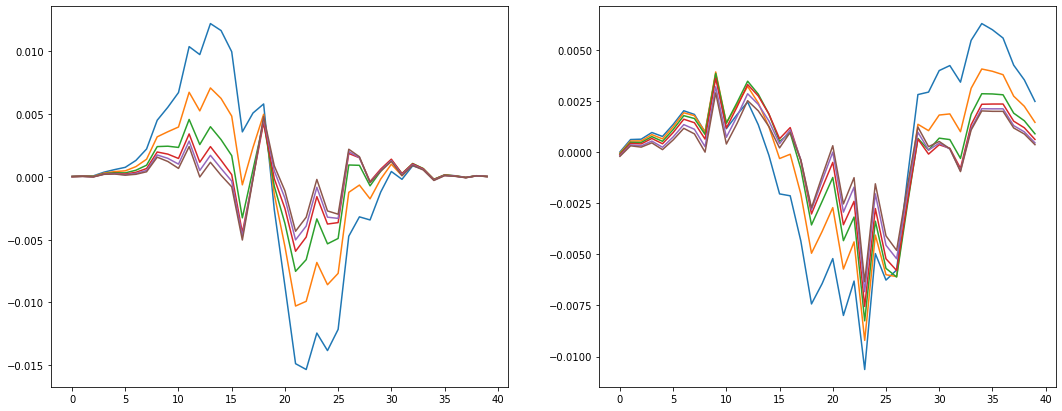

In [30]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

for ofi in range(of_niter) :
    ax[0].plot(det_hist_data_diff[ofi,0])
    ax[1].plot(det_hist_data_diff[ofi,1])
    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

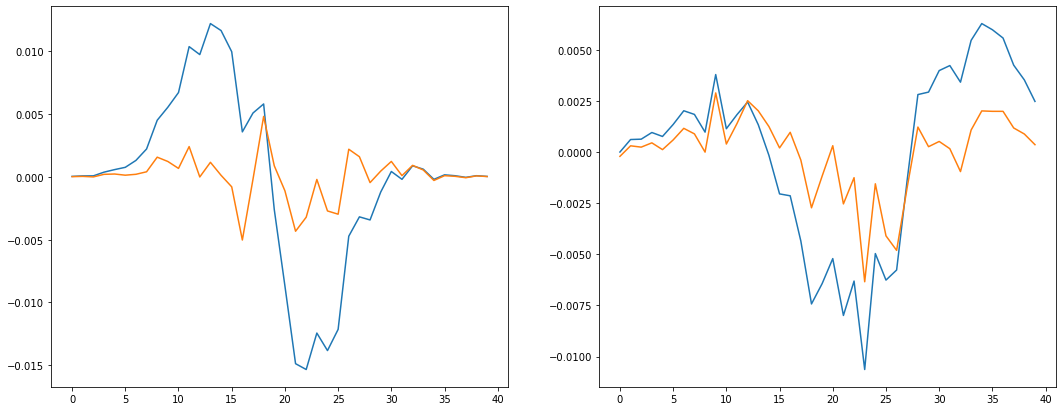

In [31]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))


ax[0].plot(det_hist_data_diff[0,0])
ax[1].plot(det_hist_data_diff[0,1])
    
ofi = of_niter-1
ax[0].plot(det_hist_data_diff[ofi,0])
ax[1].plot(det_hist_data_diff[ofi,1])

plt.show  

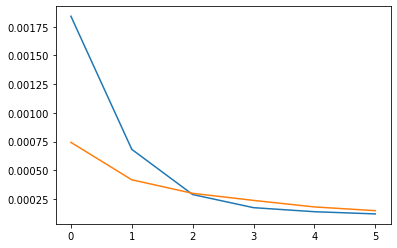

In [32]:
plt.plot( det_hist_data_sum_diff2)

In [33]:
det_hist_data_sum_diff2

array([[0.00184212, 0.00074277],
       [0.0006817 , 0.00041645],
       [0.00028794, 0.00029841],
       [0.00017342, 0.00023676],
       [0.00013815, 0.0001798 ],
       [0.00011894, 0.00014732]])

<function matplotlib.pyplot.show(close=None, block=None)>

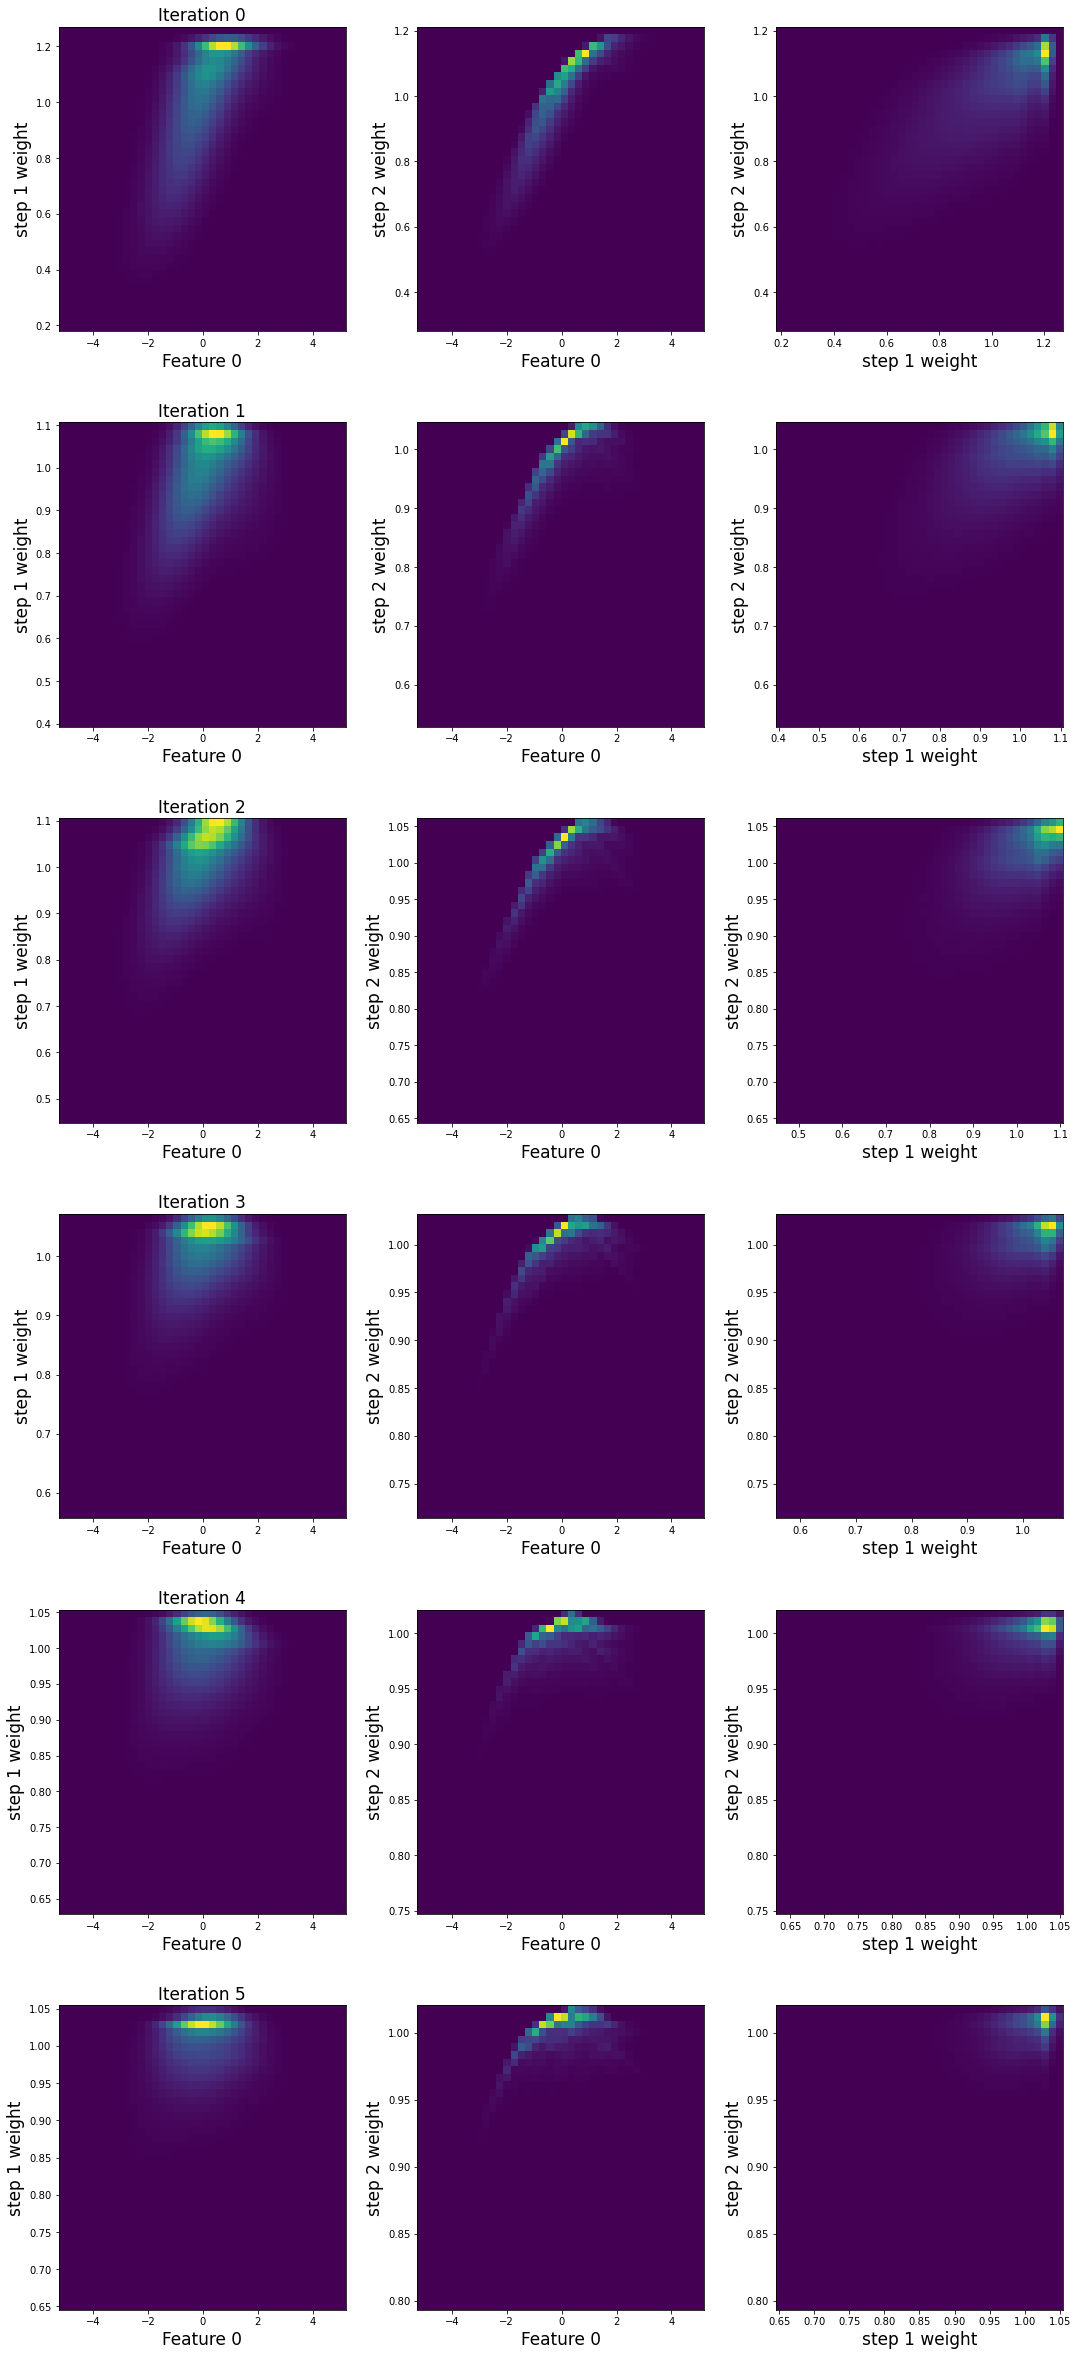

In [34]:
fig,ax = plt.subplots( of_niter, 3, figsize=(18,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist2d( train_pts[:,0], of_weights[ofi,0,:], bins=[hbins,hbins] )
    ax[ofi][1].hist2d( train_pts[:,0], of_weights[ofi,1,:], bins=[hbins,hbins] )
    ax[ofi][2].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'Feature 0', fontsize=lfontsize )
    ax[ofi][0].set_ylabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'Feature 0', fontsize=lfontsize )
    ax[ofi][1].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][2].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

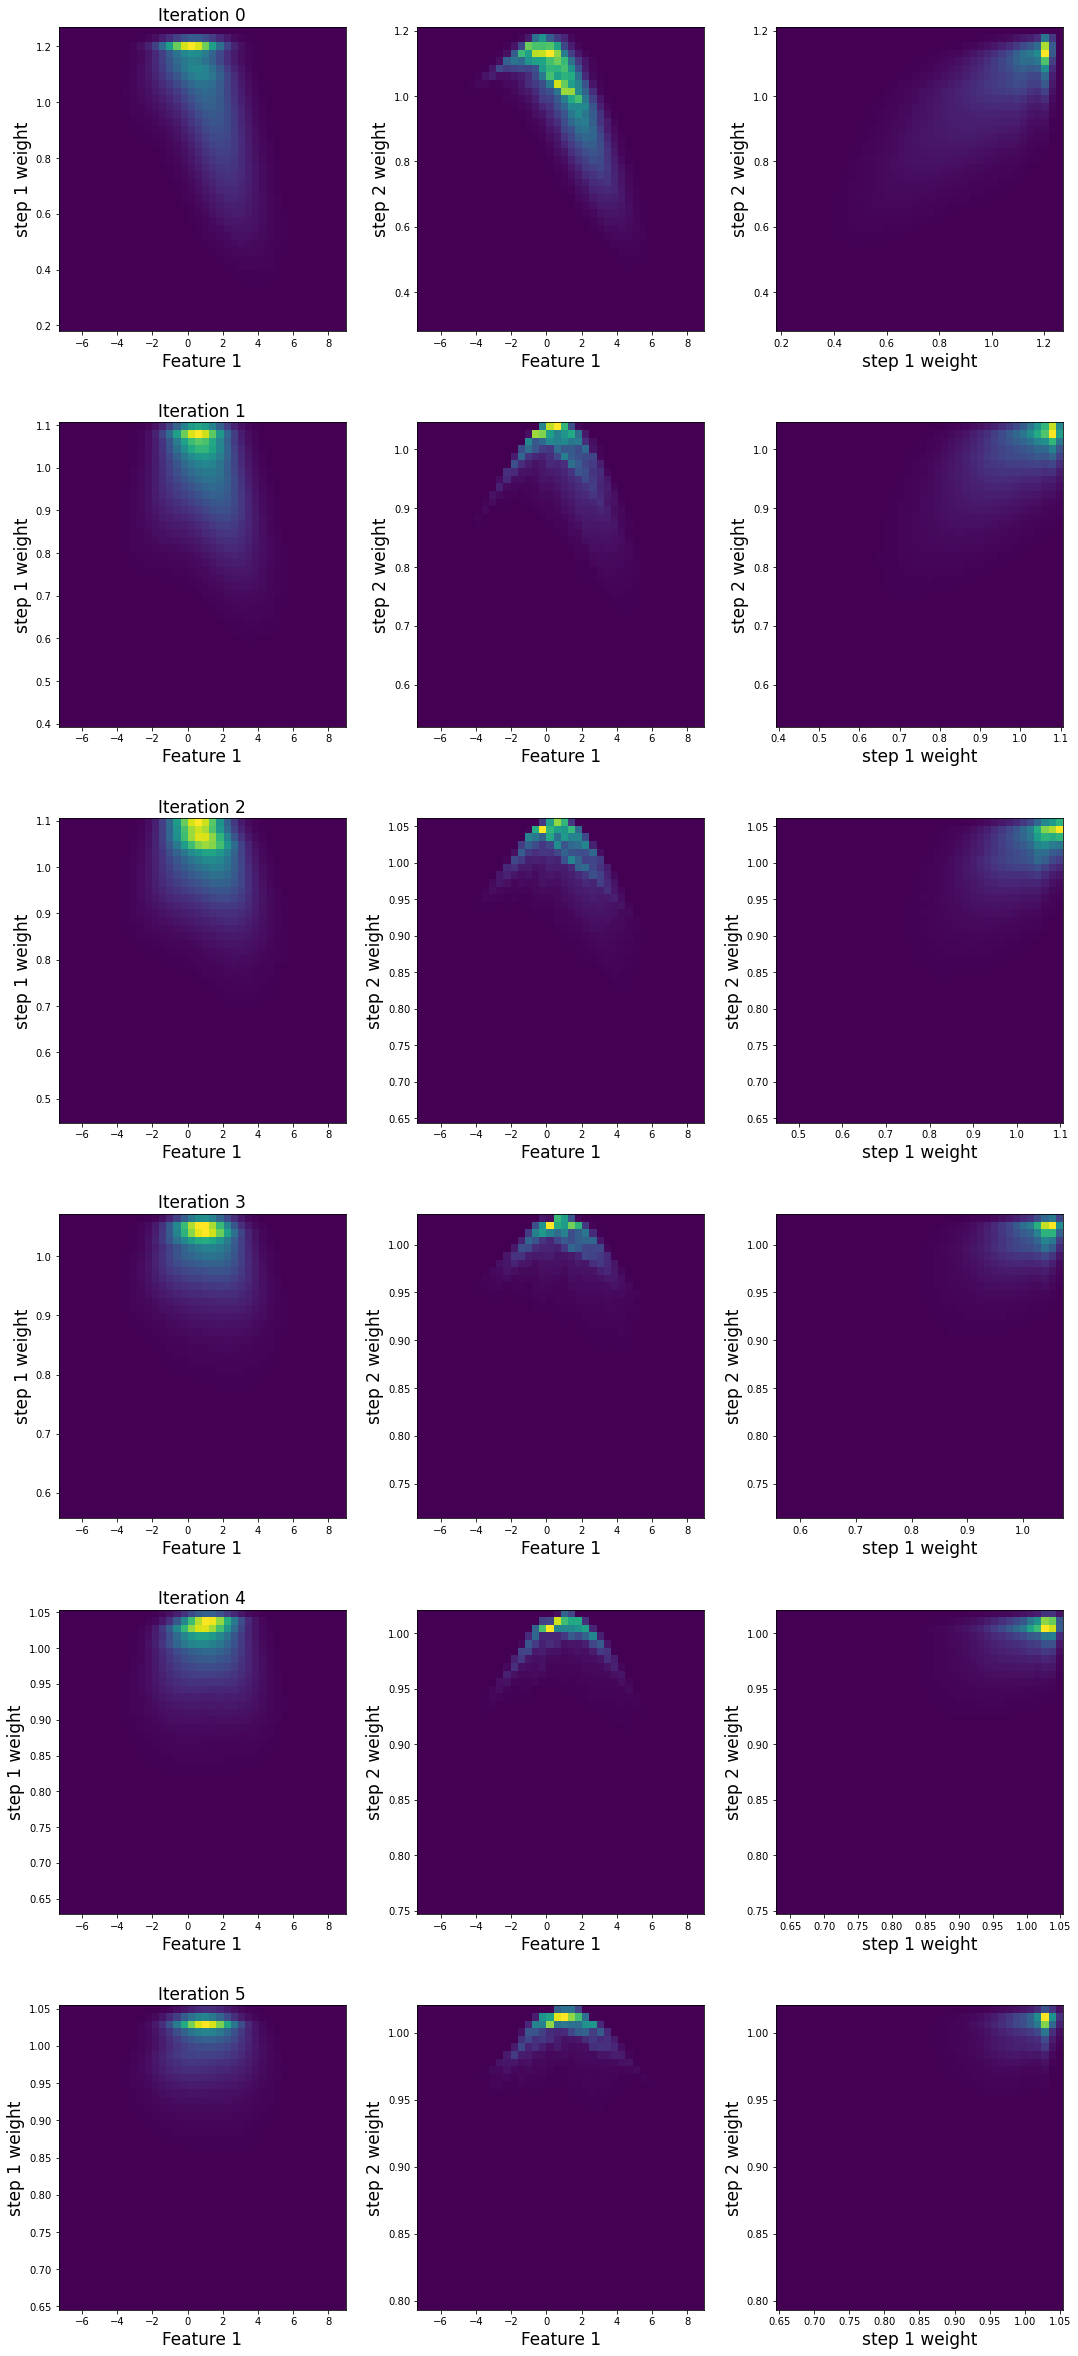

In [35]:
fig,ax = plt.subplots( of_niter, 3, figsize=(18,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist2d( train_pts[:,1], of_weights[ofi,0,:], bins=[hbins,hbins] )
    ax[ofi][1].hist2d( train_pts[:,1], of_weights[ofi,1,:], bins=[hbins,hbins] )
    ax[ofi][2].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'Feature 1', fontsize=lfontsize )
    ax[ofi][0].set_ylabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'Feature 1', fontsize=lfontsize )
    ax[ofi][1].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][2].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

In [36]:
max_step2_weight = np.max( of_weights[of_niter-1,1,:] )
max_push_weight = np.max( final_push_weights )

<function matplotlib.pyplot.show(close=None, block=None)>

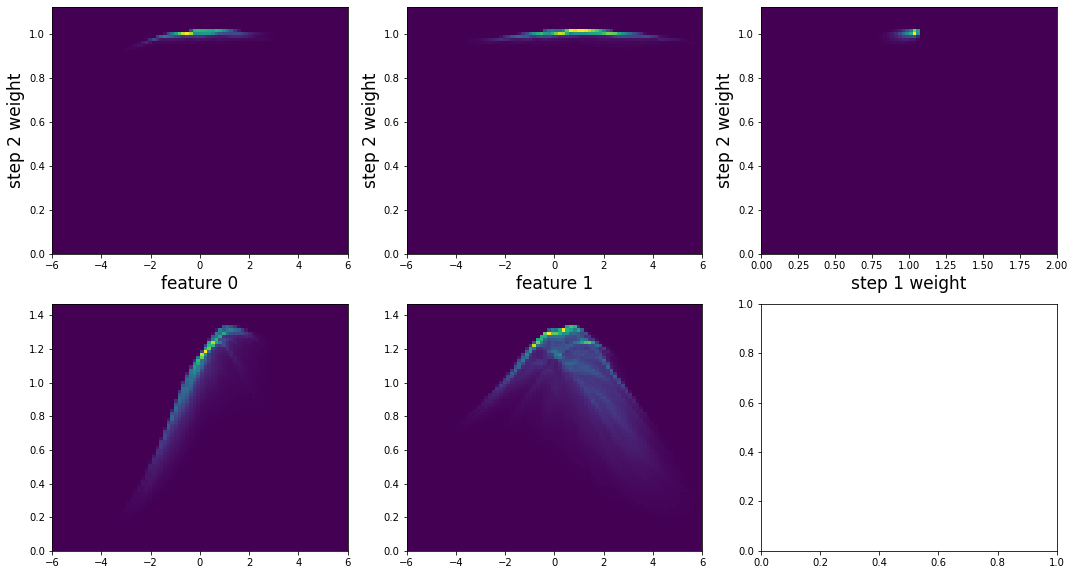

In [37]:
fig,ax = plt.subplots( 2, 3, figsize=(18,10))

hmin=-6
hmax=6
hbins=80

ax[0][0].hist2d( train_pts[:,0], of_weights[of_niter-1,1,:], bins=[hbins,hbins], range=([hmin,hmax],[0.,1.1*max_step2_weight]))

ax[0][1].hist2d( train_pts[:,1], of_weights[of_niter-1,1,:], bins=[hbins,hbins], range=([hmin,hmax],[0.,1.1*max_step2_weight]))

ax[0][2].hist2d( of_weights[3,0,:], of_weights[of_niter-1,1,:], bins=[hbins,hbins], range=([0.,2.],[0.,1.1*max_step2_weight]))


ax[1][0].hist2d( train_pts[:,0], final_push_weights, bins=[hbins,hbins], range=([hmin,hmax],[0.,1.1*max_push_weight]))

ax[1][1].hist2d( train_pts[:,1], final_push_weights, bins=[hbins,hbins], range=([hmin,hmax],[0.,1.1*max_push_weight]))




lfontsize = 17

ax[0][0].set_xlabel( 'feature 0', fontsize=lfontsize )
ax[0][0].set_ylabel( 'step 2 weight', fontsize=lfontsize )


ax[0][1].set_xlabel( 'feature 1', fontsize=lfontsize )
ax[0][1].set_ylabel( 'step 2 weight', fontsize=lfontsize )

ax[0][2].set_xlabel( 'step 1 weight', fontsize=lfontsize )
ax[0][2].set_ylabel( 'step 2 weight', fontsize=lfontsize )


plt.show


In [38]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  1.001  rms 0.186      step 2 mean  1.001  rms 0.134
  iter  1 : step 1 mean  0.976  rms 0.098      step 2 mean  0.977  rms 0.060
  iter  2 : step 1 mean  1.009  rms 0.075      step 2 mean  1.009  rms 0.041
  iter  3 : step 1 mean  1.001  rms 0.055      step 2 mean  1.000  rms 0.026
  iter  4 : step 1 mean  0.994  rms 0.045      step 2 mean  0.994  rms 0.019
  iter  5 : step 1 mean  1.001  rms 0.037      step 2 mean  1.001  rms 0.014


<function matplotlib.pyplot.show(close=None, block=None)>

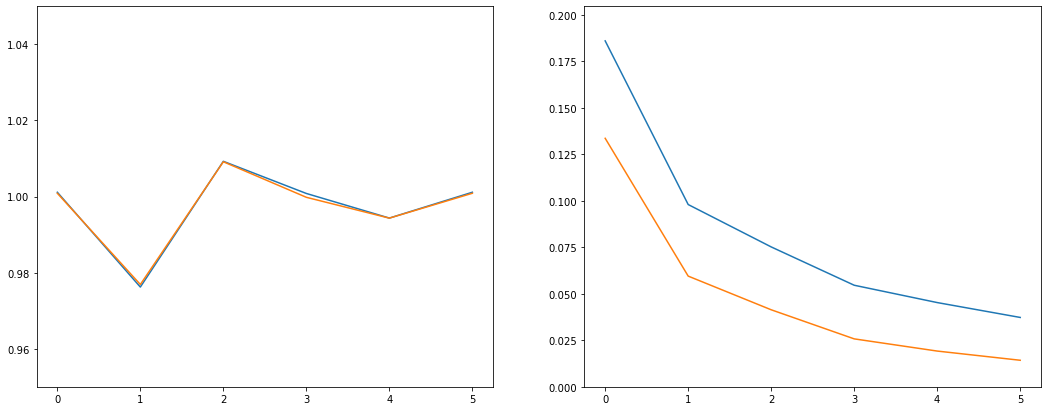

In [39]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.95, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show